## Finetuning Faster RCNN

In [2]:
import copy
from PIL import Image, ImageDraw
import numpy as np
import torch
import pandas as pd
import os
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch import nn
import optuna
from optuna.trial import TrialState
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold

In [3]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


def get_model():
    # load a pre-trained model for classification and return
    # only the features
    backbone = torchvision.models.squeezenet1_1(pretrained=True).features
    for param in backbone.parameters():
        param.requires_grad = False
    # FasterRCNN needs to know the number of
    # output channels in a backbone. For mobilenet_v2, it's 1280
    # so we need to add it here
    backbone.out_channels = 512

    # let's make the RPN generate 5 x 3 anchors per spatial
    # location, with 5 different sizes and 3 different aspect
    # ratios. We have a Tuple[Tuple[int]] because each feature
    # map could potentially have different sizes and
    # aspect ratios
    anchor_generator = AnchorGenerator(sizes=((16, 32, 64, 128),),
                                       aspect_ratios=((0.5, 0.75, 1.0, 1.5, 2.0),))

    # let's define what are the feature maps that we will
    # use to perform the region of interest cropping, as well as
    # the size of the crop after rescaling.
    # if your backbone returns a Tensor, featmap_names is expected to
    # be [0]. More generally, the backbone should return an
    # OrderedDict[Tensor], and in featmap_names you can choose which
    # feature maps to use.
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                    output_size=7,
                                                    sampling_ratio=2)

    # put the pieces together inside a FasterRCNN model
    model = FasterRCNN(backbone,
                       num_classes=2,
                       rpn_anchor_generator=anchor_generator,
                       box_roi_pool=roi_pooler)

    model.transform = GeneralizedRCNNTransform(image_mean=[0.485, 0.456, 0.406], image_std=[0.229, 0.224, 0.225], min_size=224, max_size=224)
    
    return model


def get_model_simple():
    
    model = models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    num_classes = 2  # 1 class (person) + background
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    
    #new anchorgenerator
    #anchor_sizes = ((32, 64, 128, 256, 512, ), ) * 3
    #aspect_ratios = ((0.5, 0.75, 1.0, 1.5, 2.0),) * len(anchor_sizes)
    #model.rpn.anchor_generator = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=aspect_ratios)
    
    return model

In [102]:
anchor_sizes = ((32, 64, 128, 256, 512, ), ) * 4

aspect_ratios = ((0.5, 0.75, 1.0, 1.5, 2.0),) * len(anchor_sizes)

In [244]:
model = get_model_simple()
model.transform
model.train()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvBNActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): Identity()
          )
        )
      )
      (2): InvertedResidual(
 

In [119]:
#model.eval()
%time v = model(data[0][0].unsqueeze(0))

CPU times: user 382 ms, sys: 4.04 ms, total: 386 ms
Wall time: 198 ms


In [39]:
RPNtransform = transforms.Compose([ #transforms.Resize((640,640)),
                                    transforms.ToTensor()
                                    ])


def get_strat_sample_idc(ds, train_frac, min_images_class, nr_classes=-1, seed=0):
    """
    Creates train/test split in the form of lists of indexes.
    
    :param ImageFolder ds: pytorch datasets imagefolder
    :param train_frac float: fraction of training set
    :param min_images_class int: minimum number of images per class, if a class has less, class will be skipped
    :param nr_class int: number of classes to be used, defaults to all classes (-1)
    """
    
    np.random.seed(seed)
    if nr_classes == -1:
        all_labels_unique = set(ds.targets)
    else:
        all_labels_unique = np.random.choice(a=list(set(ds.targets)), size=nr_classes, replace=False)
    
    train_idc = []
    val_idc = []
    all_labels = np.array(ds.targets)
    all_labels_idc = np.arange(0, all_labels.size)

    for label in all_labels_unique:

        label_idc = np.where(all_labels==label)[0]
        label_subset = all_labels_idc[label_idc]
        if label_subset.size < min_images_class:
            continue

        train_size = int(np.ceil(label_subset.size * train_frac))
        train = np.random.choice(a=label_subset, size=train_size, replace=False)
        train_idc += train.tolist()

        val_m = np.isin(label_subset, train, invert=True)
        val = label_subset[val_m]
        val_idc += val.tolist()
        
    return train_idc, val_idc


class RPNDataset(torch.utils.data.Dataset):
    def __init__(self, imageFolder, labelsPath, subset=None, transform=None):
        
        self.transform = transform
        
        self.df = pd.read_csv(labelsPath, names=['target', 'c1', 'c2', 'c3', 'c4', 'imageFile', 'w', 'h'])
        #print(self.df.head())
        self.labels = self.df.target
        self.x1 = (self.df.c1/self.df.w).to_numpy()
        self.y1 = (self.df.c2/self.df.h).to_numpy()
        self.x2 = ((self.df.c1 + self.df.c3)/self.df.w).to_numpy()
        self.y2 = ((self.df.c2 + self.df.c4)/self.df.h).to_numpy()
        self.images = [os.path.join(imageFolder, image) for image in self.df.imageFile]
        if type(self.df.target[0])==str:
            self.targets = [0 for i in range(len(self.df))]
            for idx, target in enumerate(self.df.target):
                if target == 'image':
                    self.targets[idx] = 1
                elif target == 'object':
                    self.targets[idx] = 0
                else:
                    print( f'error in {target} {idx}')
            self.labels = self.targets
            
        if subset is not None:
            self.x1 = self.x1[subset]
            self.y1 = self.y1[subset]
            self.x2 = self.x2[subset]
            self.y2 = self.y2[subset]
            self.labels = [self.labels[idx] for idx in subset]
            self.images = [self.images[idx] for idx in subset]
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img = Image.open(self.images[index])
        img.thumbnail((640,640))
        w = img.width #self.df.w[index]
        h = img.height #self.df.h[index]
        
        box = torch.tensor([self.x1[index]*w, self.y1[index]*h, self.x2[index]*w, self.y2[index]*h], dtype=torch.float32)
        #box = torch.tensor([self.x1[index], self.y1[index], self.x2[index], self.y2[index]], dtype=torch.float32)
        target = {
                'boxes': box,
                'labels': torch.tensor(self.labels[index]),
                'image_id' : torch.tensor(index),
                'image_path': self.images[index]
            }
        
        if not img.mode == 'RGB':
            img = img.convert('RGB')
        #if self.transform is not None:
            #img = self.transform(img)
        img = RPNtransform(img)
        return img, target

In [52]:
def collate_fn(batch):
    return tuple(zip(*batch))
data = RPNDataset('./Images', './labels_bukarest_2021-09-05-09-16-17_only_image_wo_full.csv')
batch_size = 4
train, val = get_strat_sample_idc(data, 0.6, 2)
train_data = RPNDataset('./Images', './labels_bukarest_2021-09-05-09-16-17_only_image_wo_full.csv', train)
val_data = RPNDataset('./Images', './labels_bukarest_2021-09-05-09-16-17_only_image_wo_full.csv', val)
image_datasets = {'train': train_data, 'val': val_data}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn) for x in ['train', 'val']}
data_loader_all = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

In [40]:
df = pd.read_csv('./labels_bukarest_2021-09-05-09-16-17_only_image_wo_full.csv', names=['target', 'c1', 'c2', 'c3', 'c4', 'imageFile', 'w', 'h'])
df

target   c1   c2   c3   c4                         imageFile    w    h
0     image   89  153  376  285           IMG_20210625_150705.jpg  562  600
1     image  105  155  390  287           IMG_20210625_150712.jpg  566  600
2     image   26   98  533  408           IMG_20210625_150718.jpg  597  600
3     image   21   16  559  429  IMG_20210625_150718 (copy 1).jpg  600  470
4     image   98  150  236  309           IMG_20210625_151623.jpg  450  600
..      ...  ...  ...  ...  ...                               ...  ...  ...
855  object   60   42  344  452                    web_234234.jpg  414  529
856  object   48   41  317  524                     web_front.jpg  399  600
857  object  197  126  200  397                webp_converted.jpg  640  531
858  object  141   85  200  473                     werwer233.jpg  450  600
859  object  107   36  385  353                       ysfhjlk.jpg  600  399

[860 rows x 8 columns]

In [41]:
# test dataloader
images,targets = next(iter(data_loader_all))
images = list(image for image in images)
#print(targets)
targets = [{k: v for k, v in t.items()} for t in targets]

for target in targets:
    target['boxes'] = target['boxes'].unsqueeze(0)
    target['labels'] = target['labels'].unsqueeze(0)
    target['image_id'] = target['image_id'].unsqueeze(0)
print(targets)
model.train()
output = model(images,targets)
print(output)


[{'boxes': tensor([[ 89., 153., 465., 438.]]), 'labels': tensor([1]), 'image_id': tensor([0]), 'image_path': './Images/IMG_20210625_150705.jpg'}, {'boxes': tensor([[105., 155., 495., 442.]]), 'labels': tensor([1]), 'image_id': tensor([1]), 'image_path': './Images/IMG_20210625_150712.jpg'}, {'boxes': tensor([[ 26.,  98., 559., 506.]]), 'labels': tensor([1]), 'image_id': tensor([2]), 'image_path': './Images/IMG_20210625_150718.jpg'}, {'boxes': tensor([[ 21.,  16., 580., 445.]]), 'labels': tensor([1]), 'image_id': tensor([3]), 'image_path': './Images/IMG_20210625_150718 (copy 1).jpg'}]
{'loss_classifier': tensor(0.3379, grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0381, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.2133, grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0146, grad_fn=<DivBackward0>)}


## Find best parameters with automated search

In [64]:
def tune_rpn_model(trial):
    
    strat = StratifiedKFold(2, shuffle=True)
    
    lr_bb = trial.suggest_loguniform('lr_bb', 1e-4, 1e-2)
    wd_bb = trial.suggest_loguniform('wd_bb', 1e-5, 1e-3)
    momentum = trial.suggest_uniform('momentum', 0.8, 0.99)
    
    num_epochs = 3
    
    batch_size = 4
    
    val_loss_history = []
    best_loss = 10e10

    model = get_model_simple()

    print('to update: ')
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
    
    model.train()
    optimizer = torch.optim.SGD(params_to_update, lr=lr_bb, weight_decay=wd_bb, momentum=momentum)
    
    folds = strat.split(data.targets, data.targets)

    
    for epoch in range(num_epochs):
        
        folds = strat.split(data.targets, data.targets)
        
        epoch_loss = 0
        epoch_train_loss = 0
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        train_loss = []
        val_loss = []

        for train_ds_idc, val_ds_idc in folds:

            train_data = RPNDataset('./Images', './labels_bukarest_2021-09-05-09-16-17_only_image_wo_full.csv', train_ds_idc)
            val_data = RPNDataset('./Images', './labels_bukarest_2021-09-05-09-16-17_only_image_wo_full.csv', val_ds_idc)
            train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
            val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)

            # Each epoch has a training and validation phase

            running_loss = 0.0

            running_corrects = 0

            # Iterate over data.
            with torch.set_grad_enabled(True):

                for img, targets in train_loader:

                    img = list(image for image in img)
                    #print(targets)
                    targets = [{k: v for k, v in t.items()} for t in targets]

                    for target in targets:
                        target['boxes'] = target['boxes'].unsqueeze(0)
                        target['labels'] = target['labels'].unsqueeze(0)
                        target['image_id'] = target['image_id'].unsqueeze(0)

                    loss_dict = model(img, targets)
                    #print('loss dict: ', loss_dict)
                    #print('bb example: ', targets['boxes'])

                    loss = sum(loss for loss in loss_dict.values())
                    loss_value = loss.item()
                    #print('loss: ', loss)

                    train_loss.append(loss_value) 

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()


            with torch.set_grad_enabled(False):

                for img, targets in val_loader:

                    img = list(image for image in img)
                    #print(targets)
                    targets = [{k: v for k, v in t.items()} for t in targets]

                    for target in targets:
                        target['boxes'] = target['boxes'].unsqueeze(0)
                        target['labels'] = target['labels'].unsqueeze(0)
                        target['image_id'] = target['image_id'].unsqueeze(0)

                    loss_dict = model(img, targets)
                    #print('loss dict: ', loss_dict)
                    #print('bb example: ', targets['boxes'])

                    loss = sum(loss for loss in loss_dict.values())
                    loss_value = loss.item()
                    #print('loss: ', loss)

                    val_loss.append(loss_value)
                    
        epoch_train_loss = sum(train_loss)/len(train_loss)

        print('(wrong designation) Train Loss: {:.4f}, per Instance: {:.4f} '.format(epoch_train_loss, epoch_train_loss/len(train_data)))
        print('Train avg batch Loss: {:.4f}, per Instance: {:.4f} '.format(epoch_train_loss, epoch_train_loss/batch_size)
        
        epoch_loss = sum(val_loss)/len(val_loss)

        print('(wrong designation) Val Loss: {:.4f},  per Instance: {:.4f} '.format(epoch_loss, epoch_loss/len(val_data)))
        print('Val avg batch Loss: {:.4f},  per Instance: {:.4f} '.format(epoch_loss, epoch_loss/batch_size)

              
        val_loss_history.append(epoch_loss)

        trial.report(epoch_loss, epoch)

        if trial.should_prune():
            raise optuna.TrialPruned()

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            __builtins__.best_model_wts = copy.deepcopy(model.state_dict())
    
    
    trial_loss = sum(val_loss_history)/len(val_loss_history)
    
    print('val loss history: ', val_loss_history, trial_loss)
        
    return trial_loss

#optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(),direction="minimize",study_name='bb')
study.optimize(tune_rpn_model, n_trials=21, timeout=20000, gc_after_trial=False) 

[I 2022-01-27 03:23:33,797] A new study created in memory with name: bb


to update: 
	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/2
----------
Train Loss: 0.5925, per Instance: 0.0014 
Val Loss: 0.5202,  per Instance: 0.0012 
Epoch 1/2
----------
Train Loss: 0.4392, per Instance: 0.0010 
Val Loss: 0.4106,  per Instance: 0.0010 
Epoch 2/2
----------


[I 2022-01-27 03:49:00,468] Trial 0 finished with value: 0.42793302386309257 and parameters: {'lr_bb': 0.0002459798562677551, 'wd_bb': 0.0008669095144386614, 'momentum': 0.8430747449188027}. Best is trial 0 with value: 0.42793302386309257.


Train Loss: 0.3653, per Instance: 0.0008 
Val Loss: 0.3530,  per Instance: 0.0008 
val loss history:  [0.5201755673107173, 0.41057563083315335, 0.3530478734454071] 0.42793302386309257
to update: 
	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/2
----------
Train Loss: 0.3855, per Instance: 0.0009 
Val Loss: 0.3153,  per Instance: 0.0007 
Epoch 1/2
----------
Train Loss: 0.2691, per Instance: 0.0006 
Val Loss: 0.2647,  per Instance: 0.0006 
Epoch 2/2
----------


[I 2022-01-27 04:14:31,339] Trial 1 finished with value: 0.27752458053514545 and parameters: {'lr_bb': 0.0017874895954693875, 'wd_bb': 0.0005839806545240809, 'momentum': 0.8063984904702131}. Best is trial 1 with value: 0.27752458053514545.


Train Loss: 0.2497, per Instance: 0.0006 
Val Loss: 0.2525,  per Instance: 0.0006 
val loss history:  [0.3153138669828574, 0.2647372106159175, 0.2525226640066615] 0.27752458053514545
to update: 
	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/2
----------
Train Loss: 0.5022, per Instance: 0.0012 
Val Loss: 0.4037,  per Instance: 0.0009 
Epoch 1/2
----------
Train Loss: 0.3061, per Instance: 0.0007 
Val Loss: 0.2953,  per Instance: 0.0007 
Epoch 2/2
----------


[I 2022-01-27 04:34:44,695] Trial 2 finished with value: 0.32135876795897883 and parameters: {'lr_bb': 0.0001099594960266213, 'wd_bb': 0.00038052694104678765, 'momentum': 0.9761861927761493}. Best is trial 1 with value: 0.27752458053514545.


Train Loss: 0.2755, per Instance: 0.0006 
Val Loss: 0.2651,  per Instance: 0.0006 
val loss history:  [0.40369341822548044, 0.2952628119469241, 0.2651200737045319] 0.32135876795897883
to update: 
	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/2
----------
Train Loss: 0.5079, per Instance: 0.0012 
Val Loss: 0.4154,  per Instance: 0.0010 
Epoch 1/2
----------
Train Loss: 0.3246, per Instance: 0.0008 
Val Loss: 0.3144,  per Instance: 0.0007 
Epoch 2/2
----------


[I 2022-01-27 04:54:25,279] Trial 3 finished with value: 0.33350596211298744 and parameters: {'lr_bb': 0.00023139031720328655, 'wd_bb': 2.3459558897644345e-05, 'momentum': 0.9389335814940476}. Best is trial 1 with value: 0.27752458053514545.


Train Loss: 0.2831, per Instance: 0.0007 
Val Loss: 0.2708,  per Instance: 0.0006 
val loss history:  [0.41535513468638613, 0.31436679788209776, 0.27079595377047855] 0.33350596211298744
to update: 
	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/2
----------
Train Loss: 0.2990, per Instance: 0.0007 
Val Loss: 0.2660,  per Instance: 0.0006 
Epoch 1/2
----------
Train Loss: 0.2570, per Instance: 0.0006 
Val Loss: 0.2608,  per Instance: 0.0006 
Epoch 2/2
----------


[I 2022-01-27 05:14:37,147] Trial 4 finished with value: 0.2566491387048621 and parameters: {'lr_bb': 0.007918121528189104, 'wd_bb': 3.54216626925674e-05, 'momentum': 0.8389744087723006}. Best is trial 4 with value: 0.2566491387048621.


Train Loss: 0.2386, per Instance: 0.0006 
Val Loss: 0.2432,  per Instance: 0.0006 
val loss history:  [0.265991925365395, 0.2607877812244826, 0.24316770952470876] 0.2566491387048621
to update: 
	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/2
----------
Train Loss: 0.3658, per Instance: 0.0008 
Val Loss: 0.2794,  per Instance: 0.0007 
Epoch 1/2
----------
Train Loss: 0.2546, per Instance: 0.0006 
Val Loss: 0.2475,  per Instance: 0.0006 
Epoch 2/2
----------


[I 2022-01-27 05:34:40,344] Trial 5 finished with value: 0.2525876355759891 and parameters: {'lr_bb': 0.0010853450623152653, 'wd_bb': 0.00017362955895823984, 'momentum': 0.9781699258622215}. Best is trial 5 with value: 0.2525876355759891.


Train Loss: 0.2358, per Instance: 0.0005 
Val Loss: 0.2308,  per Instance: 0.0005 
val loss history:  [0.279441192711669, 0.2474973015487194, 0.23082441246757904] 0.2525876355759891
to update: 
	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/2
----------


[I 2022-01-27 05:41:28,096] Trial 6 pruned. 


Train Loss: 0.5257, per Instance: 0.0012 
Val Loss: 0.4414,  per Instance: 0.0010 
to update: 
	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/2
----------
Train Loss: 0.3654, per Instance: 0.0008 
Val Loss: 0.2984,  per Instance: 0.0007 
Epoch 1/2
----------
Train Loss: 0.2658, per Instance: 0.0006 
Val Loss: 0.2542,  per Instance: 0.0006 
Epoch 2/2
----------


[I 2022-01-27 06:01:25,724] Trial 7 finished with value: 0.26631062617525453 and parameters: {'lr_bb': 0.0016740006625208307, 'wd_bb': 0.00018724872176750272, 'momentum': 0.856373407363569}. Best is trial 5 with value: 0.2525876355759891.


Train Loss: 0.2465, per Instance: 0.0006 
Val Loss: 0.2464,  per Instance: 0.0006 
val loss history:  [0.2983588525266559, 0.2542113237496879, 0.24636170224941992] 0.26631062617525453
to update: 
	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/2
----------
Train Loss: 0.3395, per Instance: 0.0008 
Val Loss: 0.2807,  per Instance: 0.0007 
Epoch 1/2
----------
Train Loss: 0.2512, per Instance: 0.0006 
Val Loss: 0.2452,  per Instance: 0.0006 
Epoch 2/2
----------


[I 2022-01-27 06:21:29,194] Trial 8 finished with value: 0.25529323271073306 and parameters: {'lr_bb': 0.0022492544174542166, 'wd_bb': 0.00040908371641624504, 'momentum': 0.8992782339097979}. Best is trial 5 with value: 0.2525876355759891.


Train Loss: 0.2434, per Instance: 0.0006 
Val Loss: 0.2399,  per Instance: 0.0006 
val loss history:  [0.28069627278104975, 0.24523980925894445, 0.23994361609220505] 0.25529323271073306
to update: 
	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/2
----------


[I 2022-01-27 06:28:15,551] Trial 9 pruned. 


Train Loss: 0.4384, per Instance: 0.0010 
Val Loss: 0.3408,  per Instance: 0.0008 
to update: 
	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/2
----------


[I 2022-01-27 06:34:57,759] Trial 10 pruned. 


Train Loss: 0.5643, per Instance: 0.0013 
Val Loss: 0.5670,  per Instance: 0.0013 
to update: 
	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/2
----------
Train Loss: 0.3344, per Instance: 0.0008 
Val Loss: 0.2704,  per Instance: 0.0006 
Epoch 1/2
----------
Train Loss: 0.2514, per Instance: 0.0006 
Val Loss: 0.2448,  per Instance: 0.0006 
Epoch 2/2
----------


[I 2022-01-27 06:55:29,530] Trial 11 finished with value: 0.2496235674523093 and parameters: {'lr_bb': 0.0028827166972439453, 'wd_bb': 0.00014843297786491777, 'momentum': 0.886514994450397}. Best is trial 11 with value: 0.2496235674523093.


Train Loss: 0.2396, per Instance: 0.0006 
Val Loss: 0.2337,  per Instance: 0.0005 
val loss history:  [0.2704191462447246, 0.2447803127751858, 0.23367124333701753] 0.2496235674523093
to update: 
	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/2
----------
Train Loss: 0.3110, per Instance: 0.0007 
Val Loss: 0.2556,  per Instance: 0.0006 
Epoch 1/2
----------
Train Loss: 0.2518, per Instance: 0.0006 
Val Loss: 0.2507,  per Instance: 0.0006 
Epoch 2/2
----------


[I 2022-01-27 07:15:58,419] Trial 12 finished with value: 0.24633534856278586 and parameters: {'lr_bb': 0.004299084885510622, 'wd_bb': 0.00010107475948473946, 'momentum': 0.887483101413583}. Best is trial 12 with value: 0.24633534856278586.


Train Loss: 0.2442, per Instance: 0.0006 
Val Loss: 0.2327,  per Instance: 0.0005 
val loss history:  [0.25563718043957595, 0.25069492762149487, 0.23267393762728683] 0.24633534856278586
to update: 
	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/2
----------
Train Loss: 0.3113, per Instance: 0.0007 
Val Loss: 0.2598,  per Instance: 0.0006 
Epoch 1/2
----------


[I 2022-01-27 07:29:34,375] Trial 13 pruned. 


Train Loss: 0.2570, per Instance: 0.0006 
Val Loss: 0.2613,  per Instance: 0.0006 
to update: 
	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/2
----------
Train Loss: 0.3156, per Instance: 0.0007 
Val Loss: 0.2687,  per Instance: 0.0006 
Epoch 1/2
----------
Train Loss: 0.2492, per Instance: 0.0006 
Val Loss: 0.2488,  per Instance: 0.0006 
Epoch 2/2
----------


[I 2022-01-27 07:50:04,640] Trial 14 finished with value: 0.24857214884257609 and parameters: {'lr_bb': 0.0037054868352818875, 'wd_bb': 1.2214967394255489e-05, 'momentum': 0.8838225535832692}. Best is trial 12 with value: 0.24633534856278586.


Train Loss: 0.2356, per Instance: 0.0005 
Val Loss: 0.2282,  per Instance: 0.0005 
val loss history:  [0.26873219206377313, 0.24877402928002454, 0.22821022518393067] 0.24857214884257609
to update: 
	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/2
----------
Train Loss: 0.3161, per Instance: 0.0007 
Val Loss: 0.2794,  per Instance: 0.0007 
Epoch 1/2
----------
Train Loss: 0.2673, per Instance: 0.0006 
Val Loss: 0.2538,  per Instance: 0.0006 
Epoch 2/2
----------


[I 2022-01-27 08:10:18,489] Trial 15 finished with value: 0.2575266254881834 and parameters: {'lr_bb': 0.00970143473568079, 'wd_bb': 1.0764331463376085e-05, 'momentum': 0.865473053765372}. Best is trial 12 with value: 0.24633534856278586.


Train Loss: 0.2447, per Instance: 0.0006 
Val Loss: 0.2394,  per Instance: 0.0006 
val loss history:  [0.2794129167235008, 0.2537620884400827, 0.23940487130096666] 0.2575266254881834
to update: 
	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/2
----------
Train Loss: 0.3199, per Instance: 0.0007 
Val Loss: 0.2553,  per Instance: 0.0006 
Epoch 1/2
----------


[I 2022-01-27 08:23:44,760] Trial 16 pruned. 


Train Loss: 0.2527, per Instance: 0.0006 
Val Loss: 0.2658,  per Instance: 0.0006 
to update: 
	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/2
----------


[I 2022-01-27 08:30:19,606] Trial 17 pruned. 


Train Loss: 0.4806, per Instance: 0.0011 
Val Loss: 0.3912,  per Instance: 0.0009 
to update: 
	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/2
----------
Train Loss: 0.3128, per Instance: 0.0007 
Val Loss: 0.2586,  per Instance: 0.0006 
Epoch 1/2
----------
Train Loss: 0.2489, per Instance: 0.0006 
Val Loss: 0.2466,  per Instance: 0.0006 
Epoch 2/2
----------


[I 2022-01-27 08:50:43,843] Trial 18 finished with value: 0.24672470690199622 and parameters: {'lr_bb': 0.0040450530106076145, 'wd_bb': 1.6725060874213453e-05, 'momentum': 0.8795468232712025}. Best is trial 12 with value: 0.24633534856278586.


Train Loss: 0.2379, per Instance: 0.0006 
Val Loss: 0.2350,  per Instance: 0.0005 
val loss history:  [0.2585715164464933, 0.2465802343838193, 0.2350223698756761] 0.24672470690199622
to update: 
	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/2
----------


[I 2022-01-27 08:57:39,846] Trial 19 pruned. 


Train Loss: 0.3662, per Instance: 0.0008 
Val Loss: 0.2812,  per Instance: 0.0007 


In [132]:
import pickle
pickle.dump(__builtins__.best_model_wts, open('mobilenet_320_intermediate.pkl', 'wb'))


In [66]:
model = get_model_simple()
model.load_state_dict(__builtins__.best_model_wts)

<All keys matched successfully>

In [11]:
study.best_trial

FrozenTrial(number=10, values=[9.098544498284658], datetime_start=datetime.datetime(2021, 9, 16, 17, 24, 12, 412630), datetime_complete=datetime.datetime(2021, 9, 16, 17, 30, 19, 873432), params={'lr_bb': 0.008293480654678364, 'wd_bb': 1.728911647996427e-07, 'momentum': 0.9715711702881878}, distributions={'lr_bb': LogUniformDistribution(high=0.01, low=1e-08), 'wd_bb': LogUniformDistribution(high=1.0, low=1e-07), 'momentum': UniformDistribution(high=0.99, low=0.7)}, user_attrs={}, system_attrs={}, intermediate_values={0: 8.064937233924866, 1: 9.499494925141335, 2: 9.266199082136154, 3: 10.273061037063599, 4: 7.9958391189575195, 5: 9.491735592484474}, trial_id=10, state=TrialState.COMPLETE, value=None)

## Final training with fixed parameters

In [68]:
best_and_stable={'lr_bb': 0.003, 'wd_bb': 0.0001, 'momentum': 0.88}

lr_bb = best_and_stable['lr_bb'] #study.best_params['lr_bb']
wd_bb = best_and_stable['wd_bb'] #study.best_params['wd_bb']
momentum = best_and_stable['momentum'] #study.best_params['momentum']
    
num_epochs = 6

val_loss_history = []
best_loss = 10e10

model = get_model_simple()

print('to update: ')
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

model.train()
optimizer = torch.optim.SGD(params_to_update, lr=lr_bb, weight_decay=wd_bb, momentum=momentum)


strat = StratifiedKFold(2, shuffle=True)
folds = strat.split(data.targets, data.targets)

    
for epoch in range(num_epochs):

    folds = strat.split(data.targets, data.targets)

    epoch_loss = 0
    epoch_train_loss = 0
    
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    train_loss = []
    val_loss = []

    for train_ds_idc, val_ds_idc in folds:

        train_data = RPNDataset('./Images', './labels_bukarest_2021-09-05-09-16-17_only_image_wo_full.csv', train_ds_idc)
        val_data = RPNDataset('./Images', './labels_bukarest_2021-09-05-09-16-17_only_image_wo_full.csv', val_ds_idc)
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
        val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)


        # Each epoch has a training and validation phase

        running_loss = 0.0

        running_corrects = 0

        # Iterate over data.
        with torch.set_grad_enabled(True):

            for img, targets in train_loader:

                img = list(image for image in img)
                #print(targets)
                targets = [{k: v for k, v in t.items()} for t in targets]

                for target in targets:
                    target['boxes'] = target['boxes'].unsqueeze(0)
                    target['labels'] = target['labels'].unsqueeze(0)
                    target['image_id'] = target['image_id'].unsqueeze(0)

                loss_dict = model(img, targets)
                #print('loss dict: ', loss_dict)
                #print('bb example: ', targets['boxes'])

                loss = sum(loss for loss in loss_dict.values())
                loss_value = loss.item()
                #print('loss: ', loss)

                train_loss.append(loss_value) 

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        

        with torch.set_grad_enabled(False):

            for img, targets in val_loader:

                img = list(image for image in img)
                #print(targets)
                targets = [{k: v for k, v in t.items()} for t in targets]

                for target in targets:
                    target['boxes'] = target['boxes'].unsqueeze(0)
                    target['labels'] = target['labels'].unsqueeze(0)
                    target['image_id'] = target['image_id'].unsqueeze(0)

                loss_dict = model(img, targets)
                #print('loss dict: ', loss_dict)
                #print('bb example: ', targets['boxes'])

                loss = sum(loss for loss in loss_dict.values())
                loss_value = loss.item()
                #print('loss: ', loss)

                val_loss.append(loss_value)

    epoch_train_loss = sum(train_loss)/len(train_loss)

    print('(old designation:) Train Loss: {:.4f}, per Instance: {:.4f} '.format(epoch_train_loss, epoch_train_loss/len(train_data)))
    print('Train avg batch Loss: {:.4f}, per Instance: {:.4f} '.format(epoch_train_loss, epoch_train_loss/batch_size)

    
    epoch_loss = sum(val_loss)/len(val_loss)

    print('Val Loss: {:.4f},  per Instance: {:.4f} '.format(epoch_loss, epoch_loss/len(val_data)))
    print('Val avg batch Loss: {:.4f},  per Instance: {:.4f} '.format(epoch_loss, epoch_loss/batch_size)

    val_loss_history.append(epoch_loss)

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_model_wts = copy.deepcopy(model.state_dict())

print('Val Batch Loss History: ', val_loss_history)            
            
import pickle
pickle.dump(best_model_wts, open('mobilenet_320_all_27_01_22_2.pkl', 'wb'))

to update: 
	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/5
----------
Train Loss: 0.2110, per Instance: 0.0005 
Val Loss: 0.2207,  per Instance: 0.0005 
Epoch 1/5
----------
Train Loss: 0.2142, per Instance: 0.0005 
Val Loss: 0.2142,  per Instance: 0.0005 
Epoch 2/5
----------
Train Loss: 0.2085, per Instance: 0.0005 
Val Loss: 0.2121,  per Instance: 0.0005 
Epoch 3/5
----------
Train Loss: 0.2114, per Instance: 0.0005 
Val Loss: 0.2060,  per Instance: 0.0005 
Epoch 4/5
----------
Train Loss: 0.2022, per Instance: 0.0005 
Val Loss: 0.2028,  per Instance: 0.0005 
Epoch 5/5
----------
Train Loss: 0.2029, per Instance: 0.0005 
Val Loss: 0.2036,  per Instance: 0.0005 
Val Loss History:  [0.22069720013274086, 0.2141528754081163, 0.2120535074112316, 0.2060279136661578, 0.2027663668376152, 0.2035550749688237]


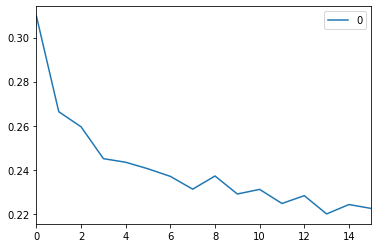

In [37]:
pd.DataFrame(val_loss_history).plot() #700

In [66]:
import pickle
#pickle.dump(model.state_dict(), open('mobilenet_test_size.pkl', 'wb'))
model_dict = pickle.load(open('mobilenet_320_all_27_01_22.pkl', 'rb'))
best_model_wts = model_dict
model = get_model_simple()
model.load_state_dict(model_dict)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvBNActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): Identity()
          )
        )
      )
      (2): InvertedResidual(
 

In [170]:
output = model(data[34][0].unsqueeze(0))
bboxes = output[0]['boxes']
bb = bboxes.detach().numpy()
bb

array([[  0.      ,   0.      , 396.47394 , 600.      ],
       [164.80904 ,   0.      , 325.77173 , 600.      ],
       [ 21.64092 , 190.80531 , 355.7829  , 541.3575  ],
       [448.76782 ,   0.      , 450.      , 478.04846 ],
       [  0.      , 593.9507  , 218.88751 , 599.7328  ],
       [ 55.374767,   0.      , 426.38568 , 322.70743 ],
       [138.71976 , 340.2059  , 184.53821 , 500.23218 ]], dtype=float32)

[47.240501403808594, 33.239803314208984, 412.20489501953125, 587.9520874023438]
[20.4739933013916, 54.47047805786133, 319.4468688964844, 577.789306640625]
[35.301177978515625, 0.0, 480.0, 590.4498901367188]
[]
[173.36634826660156, 37.26243591308594, 379.2930603027344, 531.559326171875]


<ipython-input-70-91fcac4582aa>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bbox:


[67.02005767822266, 14.94261360168457, 252.08631896972656, 298.1293640136719]
[143.56150817871094, 0.0, 496.62078857421875, 596.5399169921875]
[]
[2.0566956996917725, 0.0, 425.0, 610.6919555664062]
[11.768864631652832, 22.97674560546875, 310.4698791503906, 604.7589111328125]
[64.95623779296875, 49.88222885131836, 438.2286682128906, 555.3967895507812]
[134.6286163330078, 145.08963012695312, 514.6573486328125, 528.8881225585938]
[35.728363037109375, 7.765941619873047, 397.4449462890625, 541.3016357421875]
[15.802597045898438, 45.00751876831055, 438.46600341796875, 527.922119140625]
[37.5614128112793, 59.374114990234375, 524.0698852539062, 498.23980712890625]
[62.494651794433594, 105.38525390625, 539.3231201171875, 555.2208251953125]
[351.691162109375, 216.3088836669922, 441.71722412109375, 311.6432800292969]
[194.480224609375, 69.63935089111328, 345.65179443359375, 443.1997985839844]
[0.0, 28.111846923828125, 450.0, 495.0177307128906]
[93.11201477050781, 99.44557189941406, 405.2599487304

[73.917236328125, 65.61193084716797, 339.9473876953125, 446.93328857421875]
[69.67180633544922, 86.73789978027344, 393.7823181152344, 467.50128173828125]
[155.56326293945312, 67.31071472167969, 491.1935729980469, 343.38287353515625]
[]
[114.02652740478516, 108.78205871582031, 344.87646484375, 462.6143493652344]
[]
[42.656394958496094, 18.6423397064209, 560.162841796875, 437.21600341796875]
[58.05597686767578, 64.14576721191406, 505.130126953125, 368.5614318847656]
[70.44482421875, 96.57971954345703, 206.87185668945312, 372.6866455078125]
[57.82756423950195, 47.9504508972168, 509.82135009765625, 354.0790710449219]
[84.68126678466797, 104.49708557128906, 538.0289306640625, 462.4963073730469]
[110.31180572509766, 80.90251159667969, 485.20458984375, 503.9098815917969]
[136.4505615234375, 76.0229721069336, 470.2218933105469, 331.61224365234375]
[160.06674194335938, 162.82411193847656, 481.02264404296875, 346.9153747558594]
[158.4356689453125, 165.85345458984375, 422.2062683105469, 491.49105

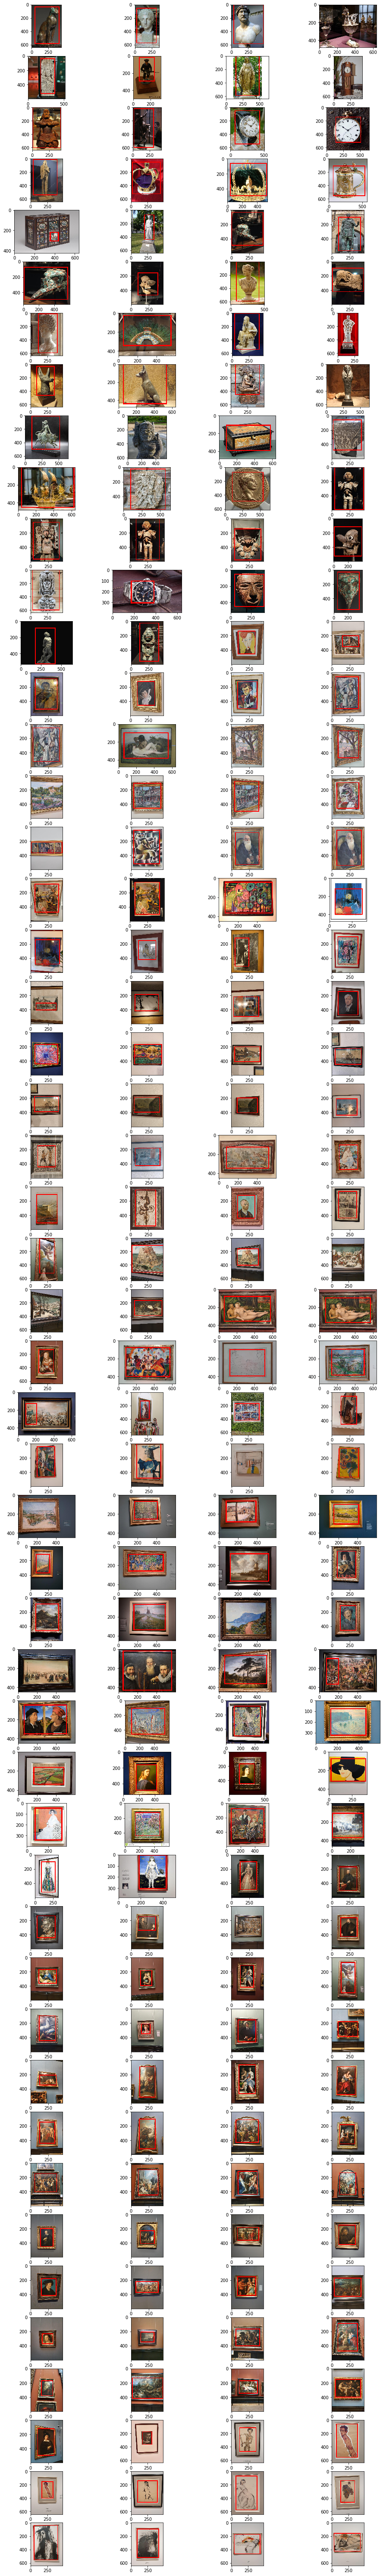

In [70]:
import matplotlib.pyplot as plt

model.load_state_dict(best_model_wts)
model.eval()

fig = plt.figure(figsize=(16, 140))
columns = 4
rows = 64
for counter, i in enumerate(val[:200]):
    
    output = model(data[i][0].unsqueeze(0))
    
    bbox = output[0]['boxes'].detach().numpy()
    
    #print(bbox.shape)
    img = Image.open(data[i][1]['image_path'])
    img.thumbnail((640, 640))
    
    if bbox.shape[0]>0:
        #bbox *= [img.width, img.height, img.width, img.height/400]
        bbox = (bbox[0]).tolist()
    print(bbox)
    
    imgd = ImageDraw.Draw(img)
    
    if bbox:
        imgd.rectangle(bbox, outline='red', width=10)

    #img.show()
    try:
        fig.add_subplot(rows, columns, counter+1)
        plt.imshow(img, aspect='equal')
    except:
        pass
plt.show()

### Test with single new image

In [45]:
model.eval()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()
#scaler = transforms.Resize((500, 300))
img = Image.open('/home/vik/Pictures/art_images_manual/1006.jpeg')
img.thumbnail((640,640))
output = model(normalize(to_tensor(img)).unsqueeze(0))
print(output)
bbox = output[0]['boxes'].detach().numpy()
imgd = ImageDraw.Draw(img)
imgd.rectangle(bbox[0].tolist(), outline='red', width=10)
img.show()

[{'boxes': tensor([[243.7901,  22.8614, 494.4943, 368.9315],
        [202.4182,  43.0006, 393.5876, 306.8067],
        [184.0629,  54.6172, 296.2375, 304.7289]], grad_fn=<StackBackward>), 'labels': tensor([1, 1, 1]), 'scores': tensor([0.1949, 0.1406, 0.0708], grad_fn=<IndexBackward>)}]


## Find images with big loss

In [52]:
lossy_samples = []
lossy_samples_i = []
empty_samples = []
model.eval()

for i in range(len(data)):
    boxes = model(data[i][0].unsqueeze(0))[0]['boxes']
    if len(boxes)>0:
        box = boxes[0]
        if i<5: print(F.l1_loss(box, data[i][1]['boxes'], reduction='sum'))
        l = torch.div(F.l1_loss(box, data[i][1]['boxes'], reduction='sum'),(data.df.w[i]*data.df.h[i]))
        lossy_samples.append(l)
        lossy_samples_i.append(i)
    else:
        empty_samples.append(i)
        
    

tensor(38.3506, grad_fn=<L1LossBackward>)
tensor(26.9736, grad_fn=<L1LossBackward>)


In [53]:
lossy_samples_n = torch.stack(lossy_samples).detach().numpy()

In [54]:
biggest_losses = lossy_samples_n.argsort()[-10:]

In [55]:
print(f'Fraction of samples without bounding box: {len(empty_samples)/len(data)}')

0.05405405405405406

In [56]:
len(empty_samples)

38

In [17]:
#biggest_losses


#print(bbox.shape)
for i in biggest_losses:
    img = Image.open(data[i][1]['image_path'])
    img.thumbnail((640, 640))

    output = model(data[i][0].unsqueeze(0))

    bbox = output[0]['boxes'].detach().numpy()


    if bbox.shape[0]>0:
        #bbox *= [img.width, img.height, img.width, img.height/400]
        bbox = (bbox[0]).tolist()
    else:
        continue
    print(bbox)


    #img = img.resize((224,224))
    imgd = ImageDraw.Draw(img)

    imgd.rectangle(bbox, outline='red', width=5)
    img.show()
    print(data[i][1]['image_path'])

[8.243609428405762, 14.118119239807129, 153.892333984375, 72.02022552490234]
./Images/crop20.jpg
[99.75885009765625, 84.81229400634766, 465.39385986328125, 371.38677978515625]
./Images/20210824_121535.jpg
[54.34978485107422, 57.71140670776367, 343.9259338378906, 448.37841796875]
./Images/20210824_121252.jpg
[149.058349609375, 68.12467193603516, 460.0979309082031, 336.99505615234375]
./Images/Albertina-monet-6.jpg
[31.54073143005371, 87.3702163696289, 153.44285583496094, 140.32533264160156]
./Images/crop19.jpg
[75.36249542236328, 67.52281188964844, 483.03680419921875, 352.46954345703125]
./Images/20210824_132909.jpg
[138.30506896972656, 64.2594223022461, 531.8388671875, 354.82293701171875]
./Images/IMG-20210921-WA0019.jpg
[93.75521850585938, 147.4561309814453, 346.8591613769531, 468.951416015625]
./Images/20210917_164659.jpg


In [69]:
model(data[empty_samples[2]][0].unsqueeze(0))

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward>)}]

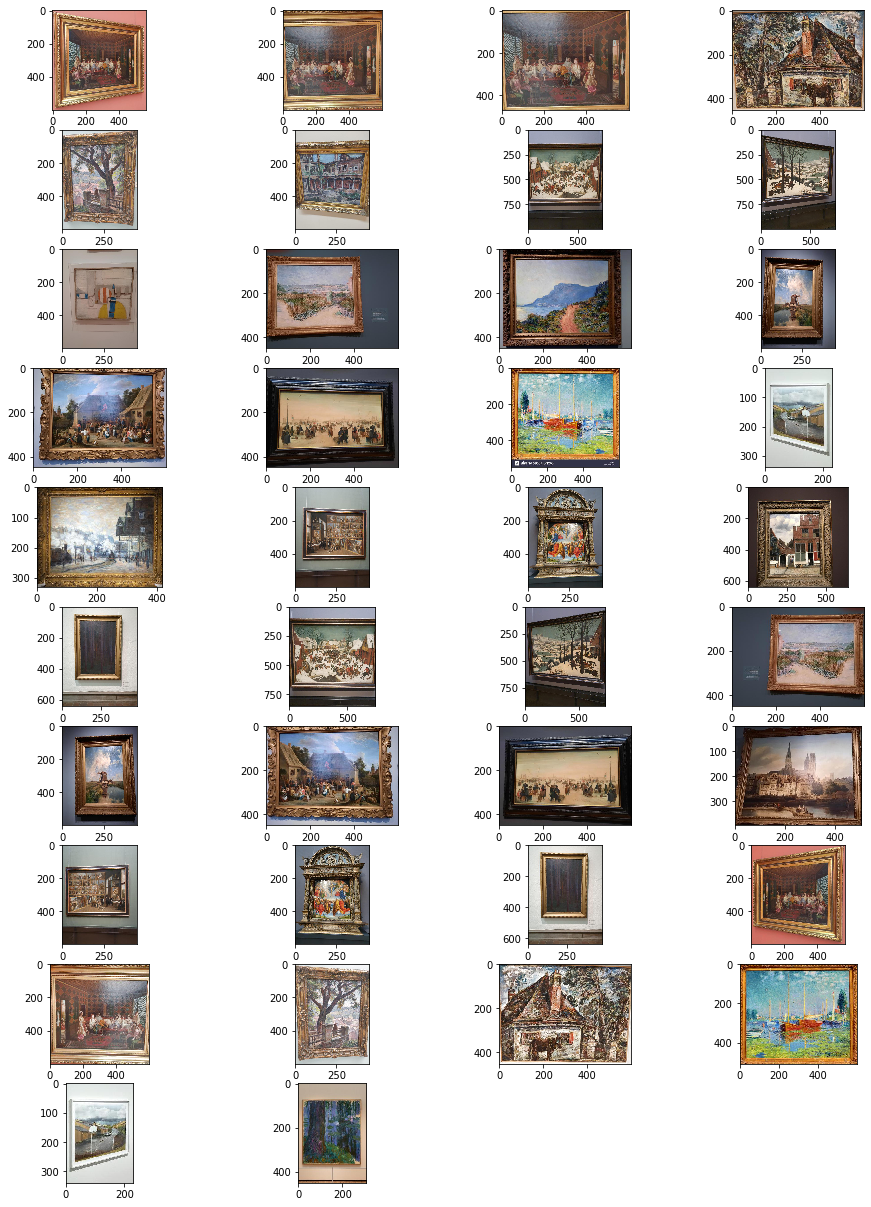

In [57]:
import shutil
#for i in empty_samples[:5]:
    #path = data[i][1]['image_path']
    #img = Image.open(data[i][1]['image_path'])
    #img.show()
    #file_path = path.split('/')[-1]
    #shutil.copy(path, 'missed_images/'+file_path)
    
fig = plt.figure(figsize=(16, 140))
columns = 4
rows = 64
for counter, i in enumerate(empty_samples):
    img = Image.open(data[i][1]['image_path'])

    fig.add_subplot(rows, columns, counter+1)
    plt.imshow(img, aspect='equal')
plt.show()

In [ ]:
Image.open('./Images/20210821_144858.jpg').show()

## Reduce size of model by deleting parts (failed)

In [5]:
import pickle
model_dict = pickle.load(open('/home/vik/code/surge/bbregression/mobilenet_320_all_2209_2.pkl', 'rb'))

In [10]:
model = get_model_simple()
model.load_state_dict(model_dict)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvBNActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): Identity()
          )
        )
      )
      (2): InvertedResidual(
 

In [11]:
model(data[0][0].unsqueeze(0))

/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[{'boxes': tensor([[ 92.2677, 126.1916, 468.7076, 442.5669]], grad_fn=<StackBackward>),
  'labels': tensor([1]),
  'scores': tensor([0.7964], grad_fn=<IndexBackward>)}]

In [36]:
torch.nn.Sequential(torch.nn.Identity())

Sequential(
  (0): Identity()
)

In [42]:
model.roi_heads.box_predictor.cls_score = torch.nn.Sequential(torch.nn.Identity(in_features=1024))
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvBNActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): Identity()
          )
        )
      )
      (2): InvertedResidual(
 

In [44]:
model.eval()
model(data[1][0].unsqueeze(0))

IndexError: index 99442 is out of bounds for dimension 0 with size 150

In [39]:
%time model(data[0][0].unsqueeze(0))

CPU times: user 354 ms, sys: 1.82 ms, total: 356 ms
Wall time: 199 ms


[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([])}]

### Convert label csv to different image size

In [26]:
def convertLabelCsvSize(old_csv, new_csv, new_width, new_height):

    df = pd.read_csv(old_csv, names=['target', 'c1', 'c2', 'c3', 'c4', 'imageFile', 'w', 'h'])
    new_size = 320
    c1 = np.round(df.c1/df.w * new_width).astype('int')
    c2 = np.round(df.c2/df.h * new_height).astype('int')
    c3 = np.round(df.c3/df.w * new_width).astype('int')
    c4 = np.round(df.c4/df.h * new_height).astype('int')
    df2 = pd.DataFrame({'target':df.target, 'c1':c1, 'c2':c2, 'c3':c3, 'c4':c4, 'imageFile':df.imageFile, 'w':new_width, 'h':new_height}, columns=None)
        
    df2.to_csv(new_csv, header=False, index=False)
    


In [27]:
old_csv = './labels_bukarest_2021-09-05-09-16-17_only_image_wo_full.csv'
new_csv = './labels_bukarest_2021-09-05-09-16-17_only_image_wo_full_320.csv'
size = 320

convertLabelCsvSize(old_csv, new_csv, size)
